## 크롤링

In [9]:
import re
import copy
import time
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By


def extract_episode_number(href):
    match = re.search(r'&no=(\d+)&', href)
    if match:
        return int(match.group(1))
    else:
        return None

### 전 회차 url 따기
def get_all_episode_url(title_id):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    episode_urls = []
    for i in range(1, 1000):
        now_episode_urls = copy.deepcopy(episode_urls)
        url = f"https://comic.naver.com/webtoon/list?titleId={title_id}&page={i}&sort=ASC"
        driver.get(url)
        time.sleep(3)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        episode_divs = soup.find_all('li', {'class': 'EpisodeListList__item--M8zq4'})
        for episode_div in episode_divs:
            a_tag = episode_div.find('a')
            href = 'https://comic.naver.com' + a_tag['href']
            episode_urls.append(href)
        episode_urls = sorted(list(set(episode_urls)))
        if now_episode_urls == episode_urls:
            break
    driver.quit()
    return episode_urls

# 댓글 DB에 삽입하기
def put_comment_to_db(title_id, episode_url):
    # Chrome 드라이버 설정
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    # 웹페이지 열기
    driver.get(episode_url)
    time.sleep(0.5)

    # 전체 댓글 클릭
    element = driver.find_element(By.XPATH, '/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[4]/div[1]/div/ul/li[2]/a/span[2]')
    element.click()

    time.sleep(2)

    while True:
        try:
            element = driver.find_element(By.XPATH, '/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[7]')
            element.click()
            # 필요한 추가 작업 수행 (예: 페이지 전환 후 대기)
            time.sleep(0.1)
            print('클릭됨!')
        except:
            print('에러 발생;')
            break
        else:
            # /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[7] 이 요소의 style의 display 속성이 'none'이 된다면 루프를 종료
            style = element.get_attribute('style')
            if 'display: none' in style:
                break

    # 댓글 요소 찾기
    comment_list_element = driver.find_element(By.XPATH, '/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul')

    # 모든 li 태그 찾기
    li_elements = comment_list_element.find_elements(By.TAG_NAME, 'li')

    # li 요소들의 텍스트를 리스트로 저장
    li_texts = [li.get_attribute('innerHTML') for li in li_elements]

    # 해당 정보를 DB에 삽입
    conn = sqlite3.connect('webtoon_comments.db')
    cursor = conn.cursor()
    for li_text in li_texts:
        cursor.execute('''
            INSERT INTO comments (TitleID, URL, CommentLi) VALUES (?, ?, ?)
        ''', (title_id, episode_url, li_text))
        
    conn.commit()
    conn.close()

    # 드라이버 종료
    driver.quit()


# 데이터 정제 ?

In [30]:
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup

conn = sqlite3.connect('webtoon_comments.db')
cursor = conn.cursor()
query = """
SELECT * FROM Comments
"""
df = pd.read_sql_query(query, conn)
conn.close()

In [31]:
df['CommentLi'].iloc[0]

'<div class="u_cbox_comment_box"><div class="u_cbox_area"><div class="u_cbox_info"><span class="u_cbox_info_main"><span class="u_cbox_name"><span class="u_cbox_name_area"><span class="u_cbox_nick_area"><span class="u_cbox_nick">noka****</span></span><span class="u_cbox_id_area"><span class="u_cbox_id">(noka****)</span></span></span></span></span><span class="u_cbox_info_sub"><span class="u_cbox_work_sub"><a href="#" class="u_cbox_btn_open" data-action="list#toggleButtons" data-param="@event"><span class="u_cbox_ico_open"></span><span class="u_cbox_in_open">옵션 열기</span></a><span class="u_cbox_work_box"><span class="u_cbox_work_inner"><a href="#" class="u_cbox_btn_userreport" data-action="report#request" data-param="commentNo:\'469460263\',objectId:\'701535_1\'" data-log="RPC.report" target="_blank"><span class="u_cbox_ico_block"></span><span class="u_cbox_in_block">신고</span></a><a href="#" class="u_cbox_btn_userblock" data-action="userBlock#requestBlock" data-param="commentNo:\'46946026

In [33]:
def extract_comment_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    content = soup.find('span', class_='u_cbox_contents')
    return content.text.strip() if content else None

df['CommentLi'].iloc[0:10].apply(extract_comment_content)

0        격기3반 잼있냐? 이제 볼려고 하는데 1화부터 재미 없는데..\n계속 봐야 되나?
1                    아니다시보니까어깨에문신ㅋㅋㄱㅋㄱㅋㄱㄱㅋㅋㄱㄱㄱㅋㄱㅋㄱㅋㄱㅋㄱ
2    지현이 멀쩡한 여고생으로 살고 있는데 그 앞에 흑지태 나타나서 아빠 죽여버리면 어떡...
3    계속 정주행하며 느낀 점\n잦은 지각과 분량미달로 욕을 많이 먹긴 했지만 탄탄한 스...
4    이제보면 '역시 넌 쓸모가 없어'라는 대사도 망상인지 진짜인지 모르겠네.. 너무 비...
5                          이제보니 동원이 마리아 플라잉 니킥맞고 멀쩡했었네
6                                             격붕이들 집합.
7                                                대기각ㄱ각
8                                           어라 봤던거네?!!
9                                                정주행간다
Name: CommentLi, dtype: object

In [34]:
df['CommentContent'] = df['CommentLi'].apply(extract_comment_content)

In [35]:
df['CommentContent']

0            격기3반 잼있냐? 이제 볼려고 하는데 1화부터 재미 없는데..\n계속 봐야 되나?
1                        아니다시보니까어깨에문신ㅋㅋㄱㅋㄱㅋㄱㄱㅋㅋㄱㄱㄱㅋㄱㅋㄱㅋㄱㅋㄱ
2        지현이 멀쩡한 여고생으로 살고 있는데 그 앞에 흑지태 나타나서 아빠 죽여버리면 어떡...
3        계속 정주행하며 느낀 점\n잦은 지각과 분량미달로 욕을 많이 먹긴 했지만 탄탄한 스...
4        이제보면 '역시 넌 쓸모가 없어'라는 대사도 망상인지 진짜인지 모르겠네.. 너무 비...
                               ...                        
93573                                                  왔구나
93574                                                   만신
93575                                                    ㅂ
93576                                                    꺄
93577                                                    1
Name: CommentContent, Length: 93578, dtype: object

In [44]:

from konlpy.tag import Okt
text = df['CommentContent'].iloc[0]
cleaned_text = re.sub(r'[^가-힣\s]', ' ', text).replace('\n', ' ')
okt = Okt()
tokens = okt.morphs(cleaned_text)
print(tokens)

['격기', '반', '잼있냐', '이제', '볼려고', '하는데', '화', '부터', '재미', '없는데', '계속', '봐야', '되나']


# 통합 ?

In [47]:
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
from konlpy.tag import Okt


### 데이터 불러오기 -> 쿼리
conn = sqlite3.connect('webtoon_comments.db')
cursor = conn.cursor()
query = """
SELECT * FROM Comments
"""
df = pd.read_sql_query(query, conn)
conn.close()


### df에 코멘트만 컬럼 추가
def extract_comment_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    content = soup.find('span', class_='u_cbox_contents')
    return content.text.strip() if content else None

df['CommentContent'] = df['CommentLi'].apply(extract_comment_content)


### 특수문자 제거 + 토크나이즈 => 통스트링으로 새로운 컬럼
okt = Okt()
def ko_text_process(text):
    if text == None:
        return ' '
    cleaned_text = re.sub(r'[^가-힣\s]', ' ', text).replace('\n', ' ')
    tokens = okt.morphs(cleaned_text)
    return ' '.join(tokens)

df['TokenizedComment'] = df['CommentContent'].apply(ko_text_process)




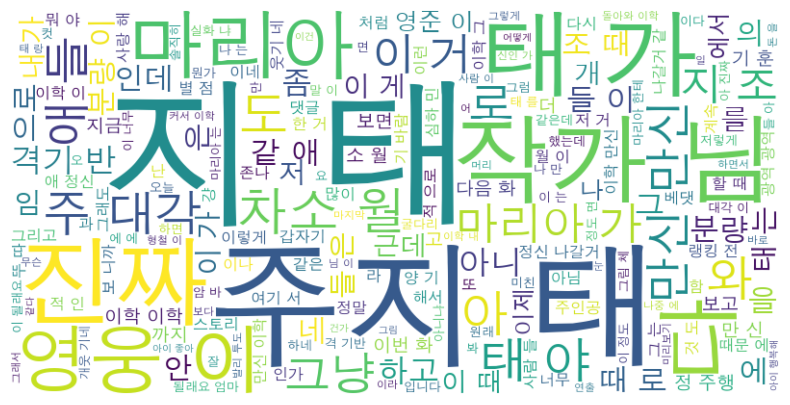

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text_for_wordcloud = ' '.join(df['TokenizedComment'])
wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf', width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
# 오 ...
# Counter 로 출력
from collections import Counter
Counter(text_for_wordcloud.split(' '))['월']

2775